In [2]:
import numpy as np
import metrolopy as uc
import matplotlib.pyplot as plt

uc.gummy.style = '+-'

In [3]:
def read_file(path):
    with open(path, "r", encoding='ISO-8859-1') as file:
        for _ in range(30):
            next(file) # skip header

        Strom = []
        Spannung = []
        
        for zeile in file:
            werte = zeile.split() # Teilen der Zeile in Werte
            strom = float(werte[0])  # "current"
            spannung = float(werte[1])  # "voltage"
            Strom.append(strom)
            Spannung.append(spannung)

    return Strom, Spannung

def fit_data(Strom, Spannung):
    fit = uc.PolyFit(Strom, Spannung, deg=1)

    steigung = fit.pf[1]
    offset = fit.pf[0]
    usteigung = fit.p[1].u
    
    return steigung, offset, usteigung

def plot_data(ax, PlotTitle, StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt):
    # Plot data points
    ax.scatter(np.array(StromHeiß)*10**6, np.array(SpannungHeiß)*10**6, label='Data hot', s=1)
    ax.scatter(np.array(StromKalt)*10**6, np.array(SpannungKalt)*10**6, label='Data cold', s=1)

    # Plot fit
    Strom = np.linspace(np.min(StromHeiß), np.max(StromHeiß), 100)
    SpannungHeißFit = FitSteigungHeiß * Strom + FitOffsetHeiß
    SpannungKaltFit = FitSteigungKalt * Strom + FitOffsetKalt
    ax.plot(Strom*10**6, SpannungHeißFit*10**6, label=r'Fit hot: $U = R \cdot I+U_0$'+'\n'+r'$R = {:.2f} \, \Omega$'.format(FitSteigungHeiß))
    ax.plot(Strom*10**6, SpannungKaltFit*10**6, label=r'Fit cold: $U = R \cdot I+U_0$'+'\n'+r'$R = {:.2f} \, \Omega$'.format(FitSteigungKalt))

    ax.set_title(PlotTitle)
    ax.set_xlabel('Current [µA]')
    ax.set_ylabel('Voltage [µV]')
    ax.legend()

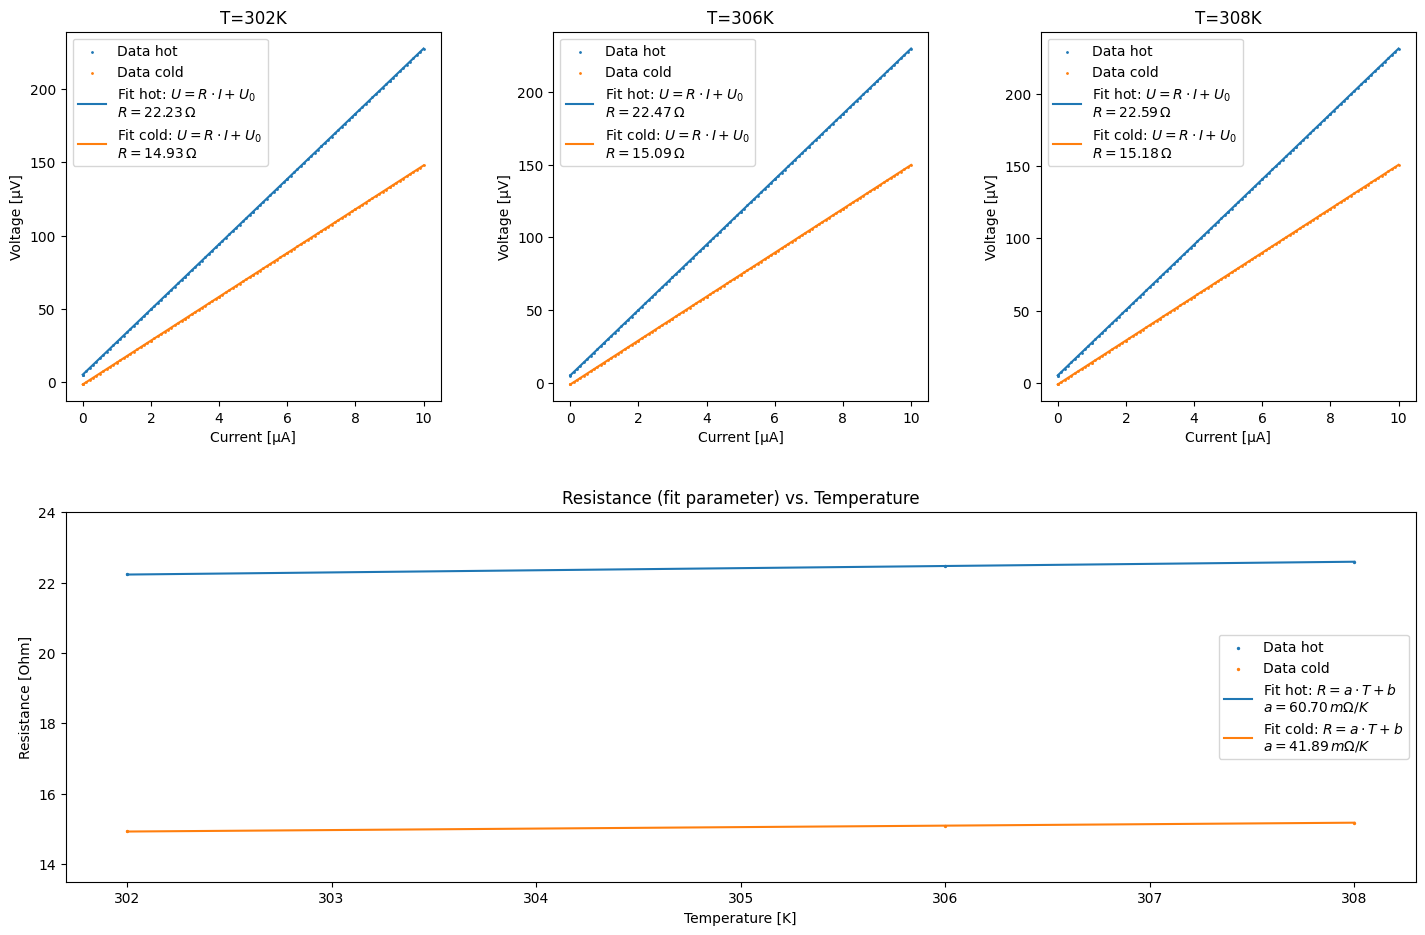

In [4]:
fig = plt.figure(figsize=(15, 10))

Temperature = []
ResistanceHeiß = []
uResistanceHeiß = []
ResistanceKalt = []
uResistanceKalt = []
for i,(path1, path2, plottitle) in enumerate((
    #("T302/2024-06-28_12-07-00 0001 T302_I0_RMessung(1,8,16,9).txt", "T302/2024-06-28_12-07-28 0001 T302_I0_RMessung(15,10,14,11).txt", "T=302K"),
    ("T302/2024-06-28_12-36-07 0001 T302_I0_ZweiteMessung_RMessung(1,8,16,9).txt", "T302/2024-06-28_12-36-34 0001 T302_I0_ZweiteMessung_RMessung(15,10,14,11).txt", "T=302K"),
    #("T306/2024-06-28_12-53-14 0001 T306_I0_RMessung(1,8,16,9).txt", "T306/2024-06-28_12-53-42 0001 T306_I0_RMessung(15,10,14,11).txt", "T=306K"),
    ("T306/2024-06-28_13-17-59 0001 T306_I0_RzweiteMessung(1,8,16,9).txt","T306/2024-06-28_13-18-26 0001 T306_I0_RzweiteMessung(15,10,14,11).txt", "T=306K"),
    #("T308/2024-06-28_13-48-29 0001 T308_I0_RMessung(1,8,16,9).txt", "T308/2024-06-28_13-22-52 0001 T308_I0_R(15,10,14,11).txt", "T=308K"),
    ("T308/2024-06-28_13-48-29 0001 T308_I0_RMessung(1,8,16,9).txt", "T308/2024-06-28_13-48-56 0001 T308_I0_RMessung(15,10,14,11).txt", "T=308K"),
)):
    StromHeiß, SpannungHeiß = read_file(path1)
    StromKalt, SpannungKalt = read_file(path2)

    FitSteigungHeiß, FitOffsetHeiß, FitUnsicherheitSteigungHeiß = fit_data(StromHeiß, SpannungHeiß)
    FitSteigungKalt, FitOffsetKalt, FitUnsicherheitSteigungKalt = fit_data(StromKalt, SpannungKalt)

    Temperature.append(int(plottitle[2:5]))
    ResistanceHeiß.append(FitSteigungHeiß)
    uResistanceHeiß.append(FitUnsicherheitSteigungHeiß)
    ResistanceKalt.append(FitSteigungKalt)
    uResistanceKalt.append(FitUnsicherheitSteigungKalt)

    plot_data(plt.subplot(2,3,i+1), plottitle, StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

fitHeiß = uc.PolyFit(Temperature, ResistanceHeiß, deg=1)
fitHeißSteigung = fitHeiß.pf[1]
fitHeißOffset = fitHeiß.pf[0]
fitKalt = uc.PolyFit(Temperature, ResistanceKalt, deg=1)
fitKaltSteigung = fitKalt.pf[1]
fitKaltOffset = fitKalt.pf[0]

plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.1, left=0.05, right=0.95)
ax = plt.subplot(2,1,2)
ax.scatter(Temperature, ResistanceHeiß, label='Data hot', s=2)
ax.scatter(Temperature, ResistanceKalt, label='Data cold', s=2)
Temperature = np.linspace(np.min(Temperature), np.max(Temperature), 100)
ResistanceHeißFit = fitHeißSteigung * Temperature + fitHeißOffset
ResistanceKaltFit = fitKaltSteigung * Temperature + fitKaltOffset
ax.plot(Temperature, ResistanceHeißFit, label=r'Fit hot: $R = a \cdot T + b$'+'\n'+r'$a = {:.2f} \, m\Omega/K$'.format(fitHeißSteigung*1000))
ax.plot(Temperature, ResistanceKaltFit, label=r'Fit cold: $R = a \cdot T + b$'+'\n'+r'$a = {:.2f} \, m\Omega/K$'.format(fitKaltSteigung*1000))
ax.set_title('Resistance (fit parameter) vs. Temperature')
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Resistance [Ohm]')
ax.set_ylim(13.5, 24)
ax.legend()

5.552019000608992
-1.3893684939778408


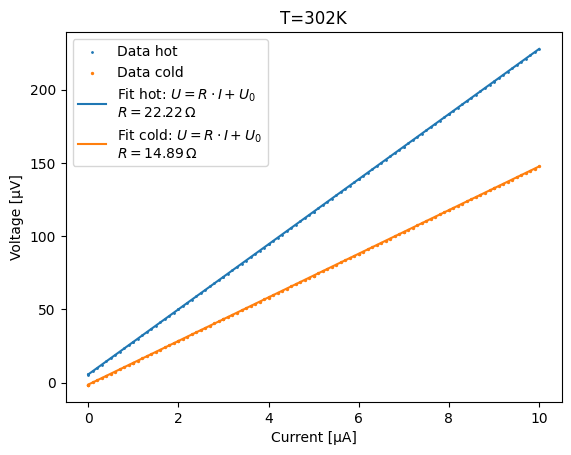

In [71]:
StromHeiß, SpannungHeiß = read_file("T302/2024-06-28_12-07-00 0001 T302_I0_RMessung(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T302/2024-06-28_12-07-28 0001 T302_I0_RMessung(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=302K', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

5.198255884084443
-1.4621976143635738


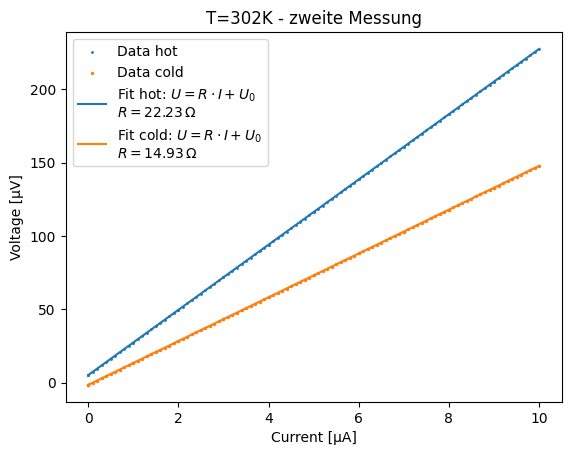

In [78]:
StromHeiß, SpannungHeiß = read_file("T302/2024-06-28_12-36-07 0001 T302_I0_ZweiteMessung_RMessung(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T302/2024-06-28_12-36-34 0001 T302_I0_ZweiteMessung_RMessung(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=302K - zweite Messung', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

5.240960295422239
-1.1954628996244114


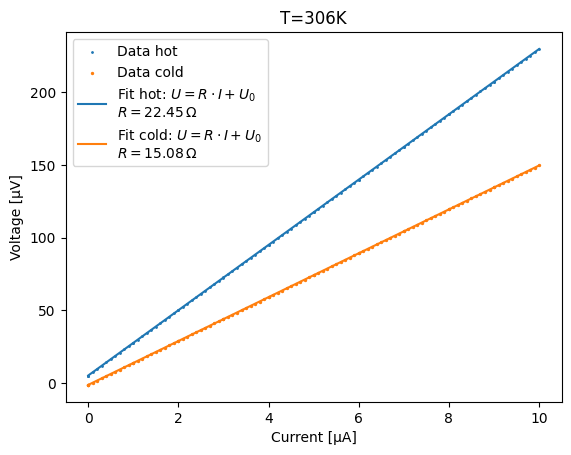

In [72]:
StromHeiß, SpannungHeiß = read_file("T306/2024-06-28_12-53-14 0001 T306_I0_RMessung(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T306/2024-06-28_12-53-42 0001 T306_I0_RMessung(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=306K', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

5.043586297097052
-1.1647900411439058


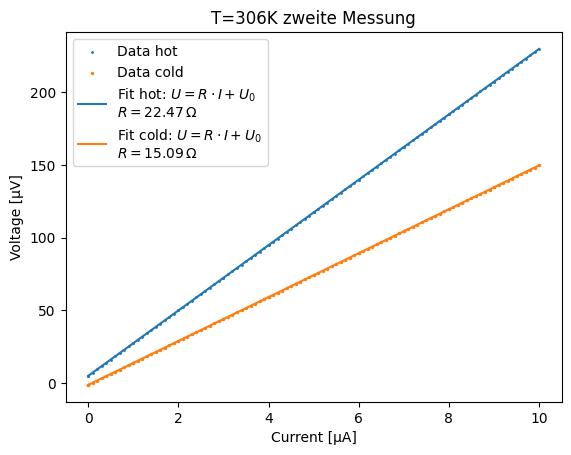

In [82]:
StromHeiß, SpannungHeiß = read_file("T306/2024-06-28_13-17-59 0001 T306_I0_RzweiteMessung(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T306/2024-06-28_13-18-26 0001 T306_I0_RzweiteMessung(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=306K - zweite Messung', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

4.762856219041854
-1.1510855284358315


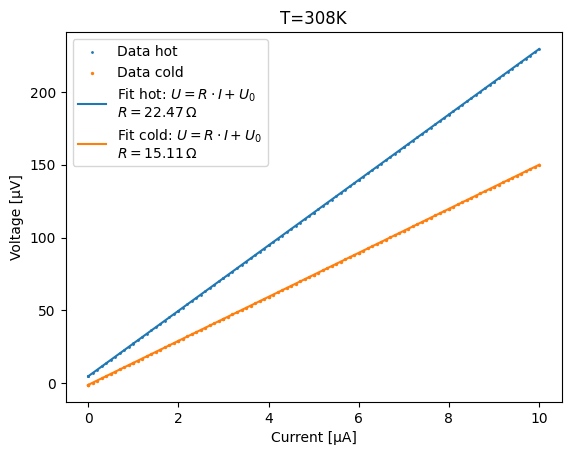

In [75]:
StromHeiß, SpannungHeiß = read_file("T308/2024-06-28_13-22-25 0001 T308_I0_R(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T308/2024-06-28_13-22-52 0001 T308_I0_R(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=308K', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

5.2411962785221755
-1.0029323939606118


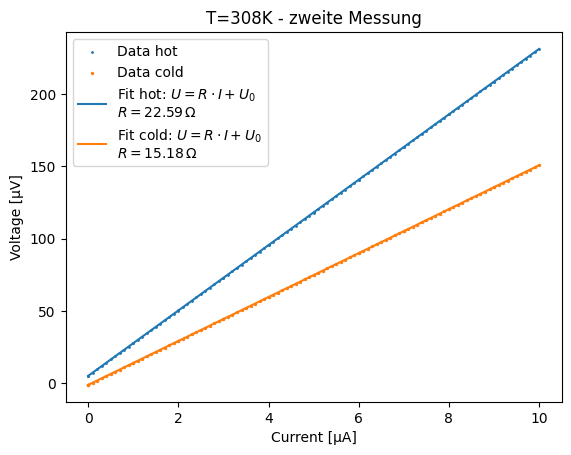

In [81]:
StromHeiß, SpannungHeiß = read_file("T308/2024-06-28_13-48-29 0001 T308_I0_RMessung(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T308/2024-06-28_13-48-56 0001 T308_I0_RMessung(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=308K - zweite Messung', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)